Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts.clean import clean_dataset
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


In [3]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 3.5 s


array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     10205
           1       0.75      0.62      0.68      3362

    accuracy                           0.86     13567
   macro avg       0.82      0.78      0.79     13567
weighted avg       0.85      0.86      0.85     13567



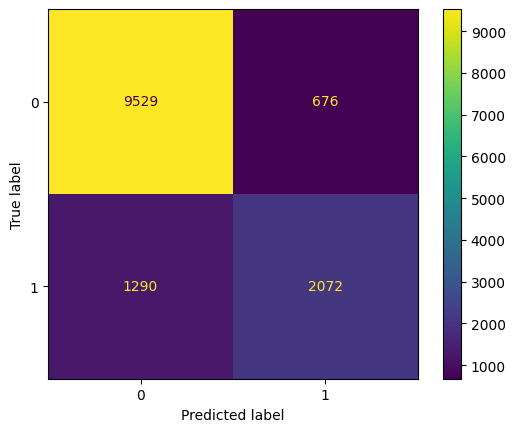

In [6]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

In [7]:
# #Uncomment if you want to find new rules with different support

# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='sex',
#     freqitem_minsupp = 0.03,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = True
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [8]:
from gfacts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if("rulesAdultFairTest_preproc.data")

## Use this for saving rules on disk
#save_rules_by_if("rulesAdultFairTest_preproc.data", rules_by_if)

In [9]:
# # run this section if you load data from disk that are computed with drop_infeasible,drop_above flags as False

# from gfacts.predicate import drop_two_above
# ifthens = gfacts.rulesbyif2rules(rules_by_if)
# ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if gfacts.recIsValid(ifs,then,X_test,True)]
# ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if drop_two_above(ifs,then,age)]
# rules_by_if = gfacts.rules2rulesbyif(ifthens)

In [28]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If capital-gain = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.57% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 4.83%.
	Protected Subgroup ' Male', 3.01% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 39.60%.
If education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.67% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 4.70%.
		Make occupation =  Exec-managerial with correctness 2.68%.
	Protected Subgroup ' Male', 3.12% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 38.28%.
		Make occupation =  Exec-managerial with correctness 22.97%.
If capital-loss = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.62% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 4.76%.
		Make occupation =  Exec-managerial wi

## Fairness definitions based on cumulative distribution of cost - correctness

## Calculation of cumulative correctness for all if clauses

In [11]:
feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = gfacts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    feature_weights=feature_weights,
    num_normalization=True
)
params = ParameterProxy(featureChanges=comparators)

In [12]:
# rules_with_cumulative = gfacts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="sex", params=params)

In [13]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if("rulesAdultFairTest_cumulative.data")

## Use this for saving rules on disk
#save_rules_by_if("rulesAdultFairTest_cumulative.data", rules_with_cumulative)

## Fairness of Coverage

If capital-gain = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.57% covered out of 4213
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.25% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.03
	Protected Subgroup ' Male', 3.01% covered out of 6606
		Make education-num = 10, occupation =  Exec-managerial with correctness 39.09% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.39
	Bias against  Female. Unfairness measure = 0.358.
	Cumulative correctness plot for the above recourses:


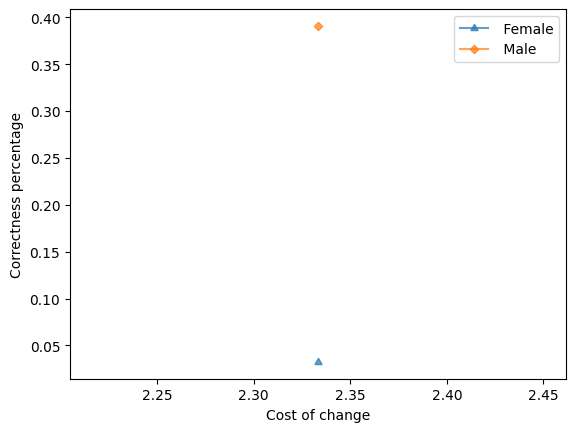

If capital-loss = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.62% covered out of 4213
		Make occupation =  Exec-managerial with correctness 1.32% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.63% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.03
	Protected Subgroup ' Male', 3.03% covered out of 6606
		Make occupation =  Exec-managerial with correctness 21.11% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Exec-managerial with correctness 38.19% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.38
	Bias against  Female. Unfairness measure = 0.356.
	Cumulative correctness plot for the above recourses:


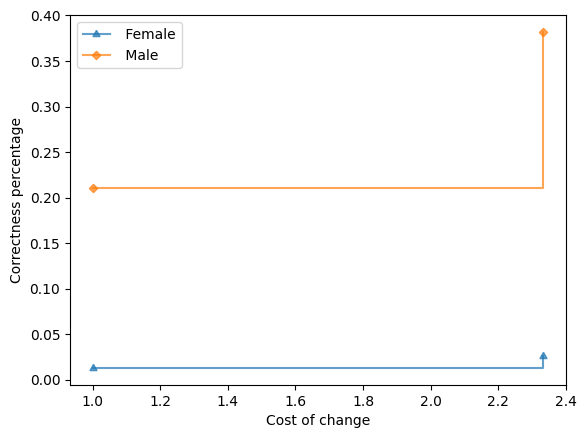

If capital-gain = 0, capital-loss = 0, education-num = 9, occupation =  Sales:
	Protected Subgroup ' Female', 4.13% covered out of 4213
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.34% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.02
	Protected Subgroup ' Male', 3.16% covered out of 6606
		Make education-num = 10, occupation =  Exec-managerial with correctness 36.06% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.36
	Bias against  Female. Unfairness measure = 0.337.
	Cumulative correctness plot for the above recourses:


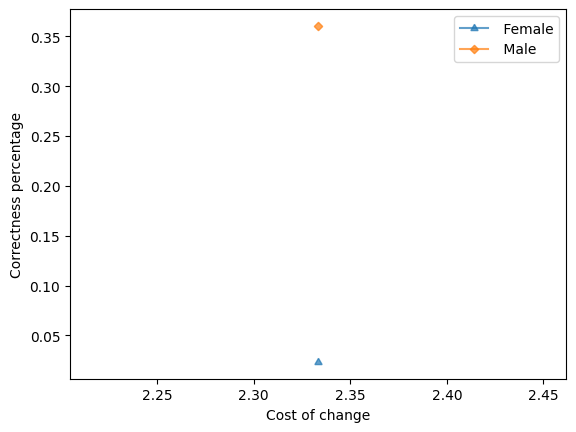

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 13.16% covered out of 4213
		Make occupation =  Prof-specialty with correctness 1.56% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 3.70% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 3.90% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 6.04% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 7.60% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 7.60% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.08
	Protected Subgroup ' Male', 3.24% covered out of 6606
		Make occupation =  Prof-specialty with correctness 14.67% and count

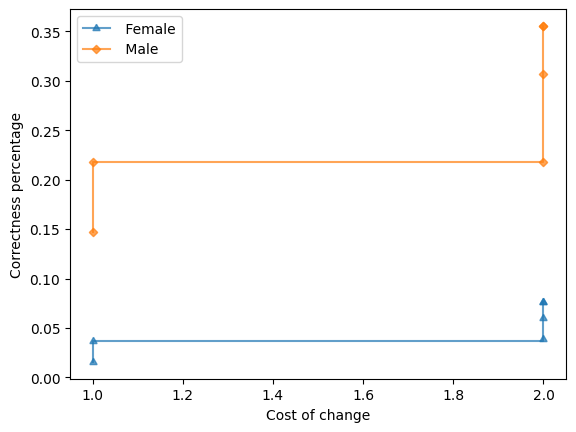

If hours-per-week = FullTime, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Female', 11.17% covered out of 4213
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 0.21% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 2.98% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 5.74% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 5.96% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 8.09% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 8.09% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 9.79% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-ma

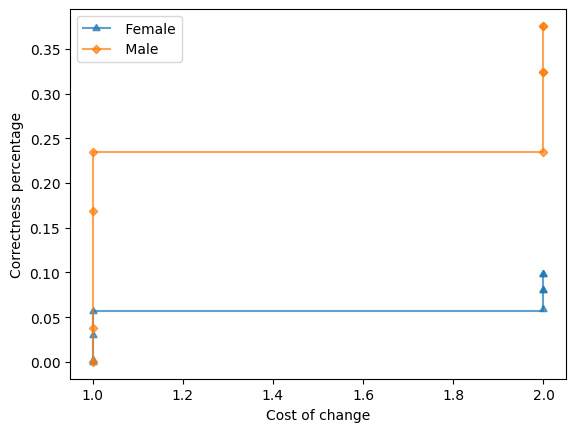

If Workclass =  Private, hours-per-week = FullTime, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 3.03% covered out of 4213
		Make occupation =  Prof-specialty with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 2.92% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 2.92% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 7.30% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 7.30% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 7.30% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.07
	Protected Subgroup ' Male', 5.67% covered out of 6606
		Make occupation =  Prof-specialty with correctness 9.86% and counterfactual c

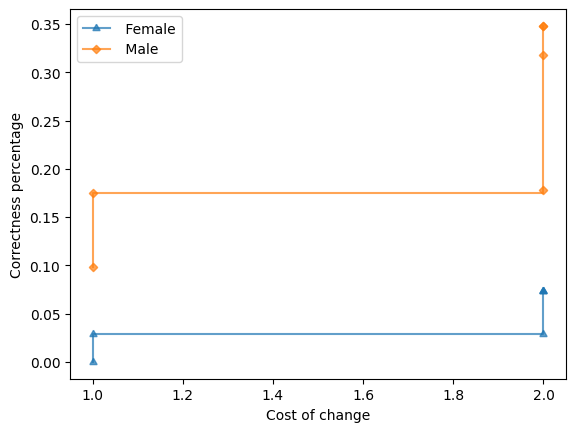

If hours-per-week = FullTime, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.89% covered out of 4213
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 1.32% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime with correctness 3.29% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 3.29% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 7.89% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 7.89% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 7.89% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 7.89% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.08


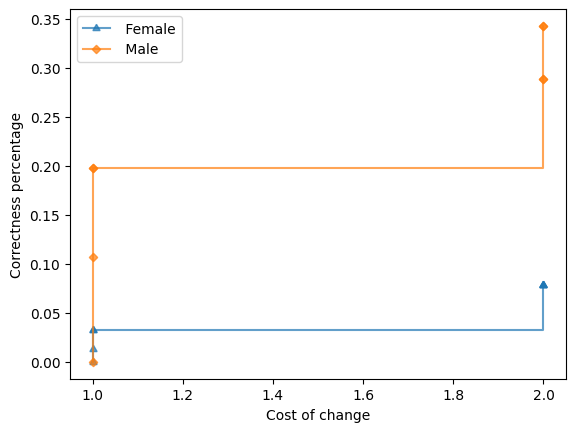

If hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Female', 4.31% covered out of 4213
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 1.18% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime with correctness 2.94% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 2.94% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 7.06% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 7.06% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 7.06% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 7.06% and counterfactual cost = 2.0.
		Aggregate cost of the above

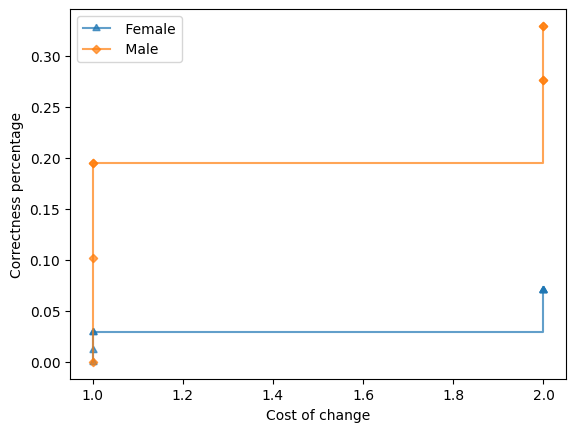

If Workclass =  Private, education-num = 11:
	Protected Subgroup ' Female', 3.84% covered out of 4213
		Make education-num = 12 with correctness 2.07% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 6.90% and counterfactual cost = 2.67.
		Make Workclass =  Self-emp-not-inc, education-num = 13 with correctness 6.90% and counterfactual cost = 3.67.
		Make Workclass =  Self-emp-inc, education-num = 13 with correctness 6.90% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.07
	Protected Subgroup ' Male', 3.09% covered out of 6606
		Make education-num = 12 with correctness 12.50% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 27.88% and counterfactual cost = 2.67.
		Make Workclass =  Self-emp-not-inc, education-num = 13 with correctness 27.88% and counterfactual cost = 3.67.
		Make Workclass =  Self-emp-inc, education-num = 13 with correctness 32.21% and counterfactual cost = 3.67.
		Aggregate cost of the abov

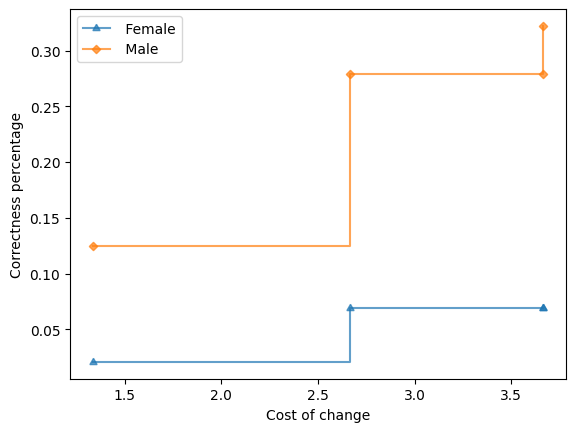

In [30]:
top_rules, subgroup_costs = gfacts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

## Fairness of Recourse at Coverage Level 

If Workclass =  Private, marital-status =  Divorced, relationship =  Not-in-family:
	Protected Subgroup ' Female', 9.65% covered out of 4213
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 35.03% and counterfactual cost = 12.0.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 42.25% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 12.00
	Protected Subgroup ' Male', 5.79% covered out of 6606
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.21% and counterfactual cost = 11.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.21% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.21% and counterfactual cost = 12.0.
		Make Workclass =  Loc

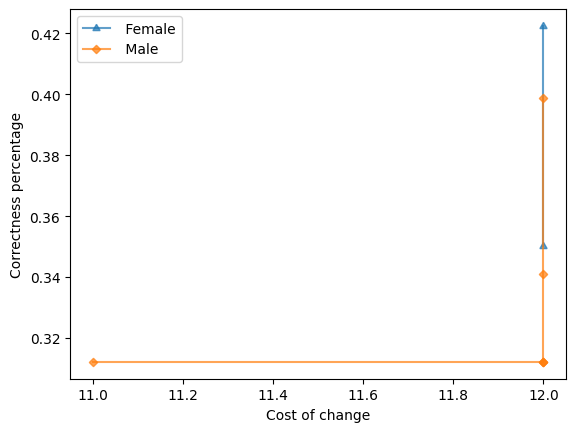

If hours-per-week = FullTime, marital-status =  Divorced, relationship =  Not-in-family:
	Protected Subgroup ' Female', 6.47% covered out of 4213
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 34.88% and counterfactual cost = 11.0.
		Make hours-per-week = MidTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 34.88% and counterfactual cost = 12.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 50.78% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with correctness 50.78% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' Male', 3.98% covered out of 6606
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 36.55% and counterfactual cost = 12.0.
		Make hours-per-

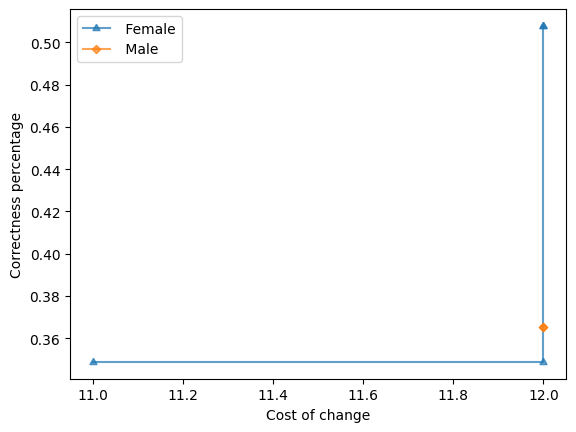

If age = (26.0, 34.0], capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 6.45% covered out of 4213
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 38.20% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 53.22% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 61.37% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' Male', 5.43% covered out of 6606
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 42.50% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 50.00% and counterfactual cost = 12.0.
		Aggregate cost of the above 

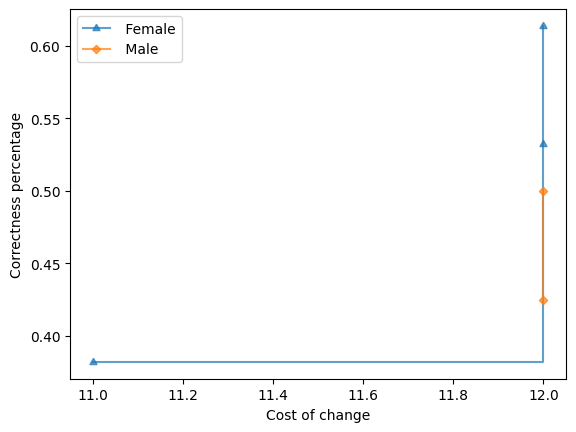

If age = (26.0, 34.0], capital-gain = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 6.20% covered out of 4213
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 38.03% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 52.99% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 61.54% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' Male', 5.36% covered out of 6606
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 41.81% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 49.37% and counterfactual cost = 12.0.
		Aggregate cost of the above 

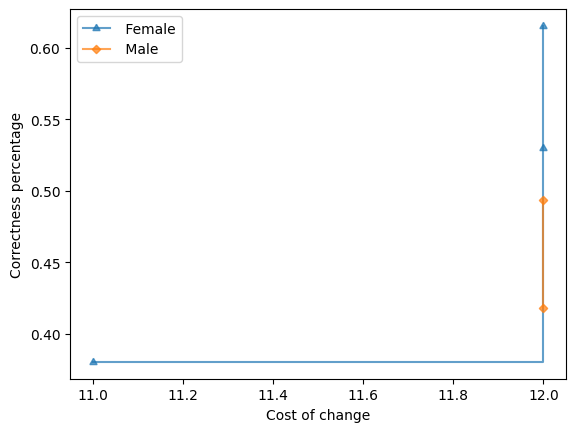

If Workclass =  Private, age = (26.0, 34.0], capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 5.09% covered out of 4213
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 32.16% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 47.37% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 54.97% and counterfactual cost = 12.0.
		Make Workclass =  Local-gov, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 54.97% and counterfactual cost = 13.0.
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 58.48% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 11.00
	Protected S

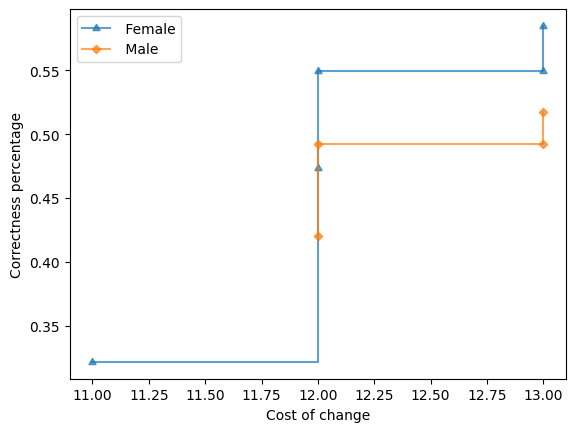

If capital-gain = 0, race =  Black:
	Protected Subgroup ' Female', 14.00% covered out of 4213
		Make capital-gain = 15024, race =  White with correctness 72.98% and counterfactual cost = 1.15.
		Aggregate cost of the above recourses = 1.15
	Protected Subgroup ' Male', 7.82% covered out of 6606
		Make capital-gain = 7298, race =  White with correctness 36.52% and counterfactual cost = 1.07.
		Make capital-gain = 7688, race =  White with correctness 38.83% and counterfactual cost = 1.08.
		Make capital-gain = 15024, race =  White with correctness 76.95% and counterfactual cost = 1.15.
		Aggregate cost of the above recourses = 1.07
	Bias against  Female. Unfairness measure = 0.077.
	Cumulative correctness plot for the above recourses:


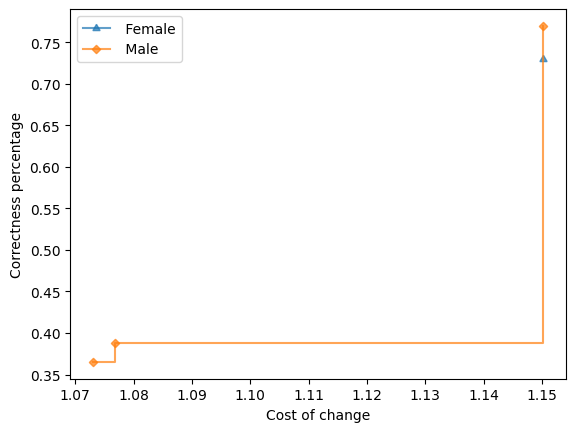

If capital-gain = 0, relationship =  Other-relative:
	Protected Subgroup ' Female', 4.11% covered out of 4213
		Make capital-gain = 7298, relationship =  Married with correctness 33.14% and counterfactual cost = 10.07.
		Make capital-gain = 7688, relationship =  Married with correctness 40.70% and counterfactual cost = 10.08.
		Make capital-gain = 15024, relationship =  Married with correctness 83.72% and counterfactual cost = 10.15.
		Aggregate cost of the above recourses = 10.07
	Protected Subgroup ' Male', 3.22% covered out of 6606
		Make capital-gain = 15024, relationship =  Married with correctness 78.18% and counterfactual cost = 10.15.
		Aggregate cost of the above recourses = 10.15
	Bias against  Male. Unfairness measure = 0.077.
	Cumulative correctness plot for the above recourses:


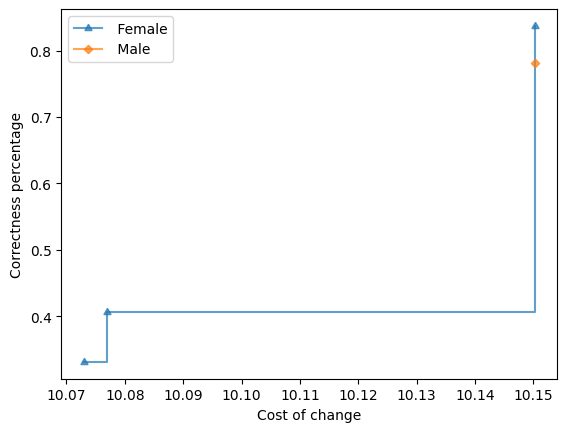

If capital-gain = 0:
	Protected Subgroup ' Female', 96.60% covered out of 4213
		Make capital-gain = 15024 with correctness 73.31% and counterfactual cost = 0.15.
		Aggregate cost of the above recourses = 0.15
	Protected Subgroup ' Male', 96.73% covered out of 6606
		Make capital-gain = 7298 with correctness 50.64% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with correctness 52.72% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with correctness 81.49% and counterfactual cost = 0.15.
		Aggregate cost of the above recourses = 0.07
	Bias against  Female. Unfairness measure = 0.077.
	Cumulative correctness plot for the above recourses:


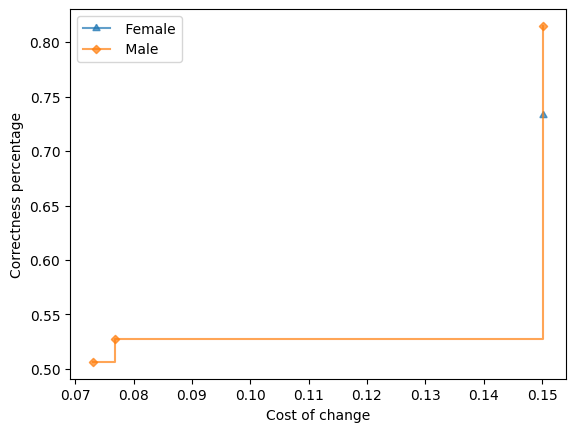

If capital-gain = 0, capital-loss = 0, marital-status =  Divorced, relationship =  Not-in-family:
	Protected Subgroup ' Female', 11.61% covered out of 4213
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 30.33% and counterfactual cost = 11.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with correctness 90.55% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with correctness 92.31% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with correctness 100.00% and counterfactual cost = 11.15.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' Male', 7.18% covered out of 6606
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with correctness 94.90% and counterfactual cost = 11.07.
		Make capital-gain = 7688

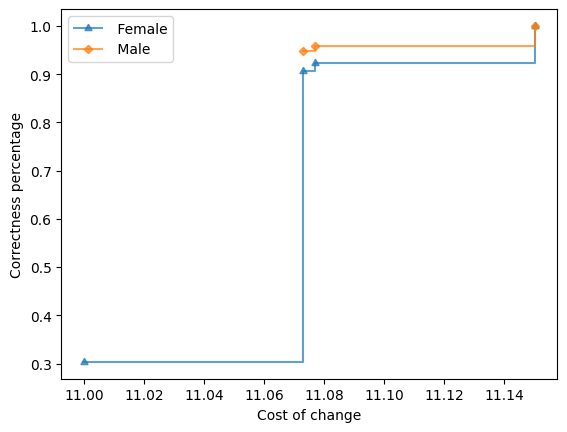

If capital-gain = 0, marital-status =  Never-married, race =  Black:
	Protected Subgroup ' Female', 6.94% covered out of 4213
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, race =  White with correctness 35.02% and counterfactual cost = 2.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, race =  White with correctness 37.91% and counterfactual cost = 2.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, race =  White with correctness 93.86% and counterfactual cost = 2.15.
		Aggregate cost of the above recourses = 2.07
	Protected Subgroup ' Male', 3.46% covered out of 6606
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, race =  White with correctness 32.68% and counterfactual cost = 2.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, race =  White with correctness 87.16% and counterfactual cost = 2.15.
		Aggregate cost of the above recourses = 2.08
	Bias against  Male. Unfairness measure = 0

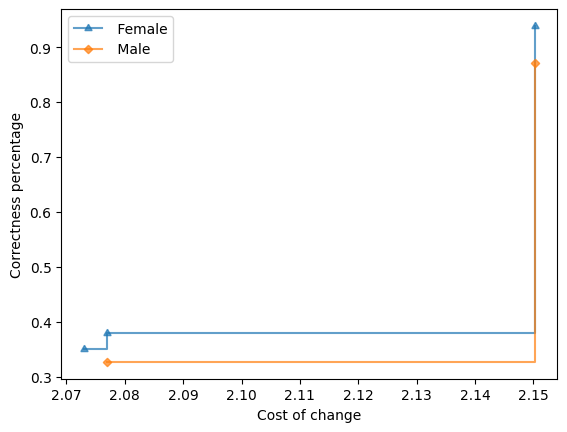

In [31]:
top_rules, subgroup_costs = gfacts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Fairness of Coverage at Recourse Budget

If capital-gain = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.57% covered out of 4213
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.25% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.03
	Protected Subgroup ' Male', 3.01% covered out of 6606
		Make education-num = 10, occupation =  Exec-managerial with correctness 39.09% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.39
	Bias against  Female. Unfairness measure = 0.358.
	Cumulative correctness plot for the above recourses:


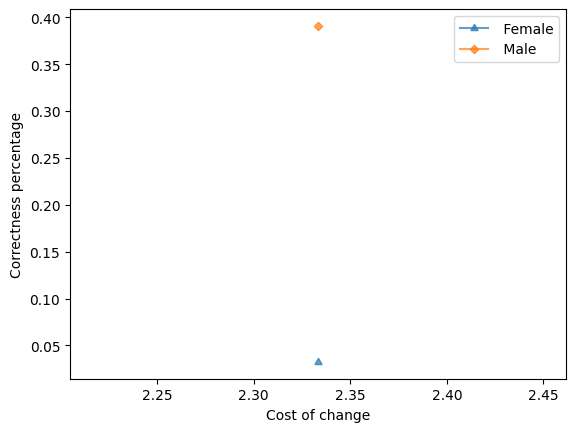

If capital-loss = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.62% covered out of 4213
		Make occupation =  Exec-managerial with correctness 1.32% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.63% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.03
	Protected Subgroup ' Male', 3.03% covered out of 6606
		Make occupation =  Exec-managerial with correctness 21.11% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Exec-managerial with correctness 38.19% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.38
	Bias against  Female. Unfairness measure = 0.356.
	Cumulative correctness plot for the above recourses:


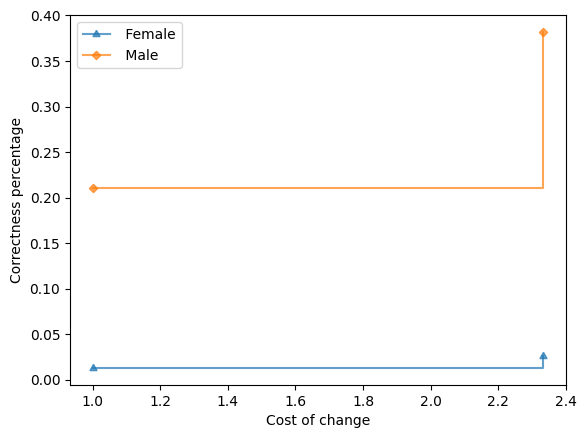

If capital-gain = 0, capital-loss = 0, education-num = 9, occupation =  Sales:
	Protected Subgroup ' Female', 4.13% covered out of 4213
		Make education-num = 10, occupation =  Exec-managerial with correctness 2.34% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.02
	Protected Subgroup ' Male', 3.16% covered out of 6606
		Make education-num = 10, occupation =  Exec-managerial with correctness 36.06% and counterfactual cost = 2.33.
		Aggregate cost of the above recourses = 0.36
	Bias against  Female. Unfairness measure = 0.337.
	Cumulative correctness plot for the above recourses:


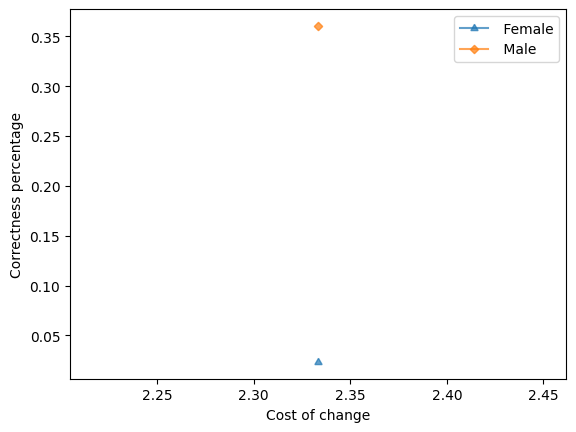

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 13.16% covered out of 4213
		Make occupation =  Prof-specialty with correctness 1.56% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 3.70% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 3.90% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 6.04% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 7.60% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 7.60% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.08
	Protected Subgroup ' Male', 3.24% covered out of 6606
		Make occupation =  Prof-specialty with correctness 14.67% and count

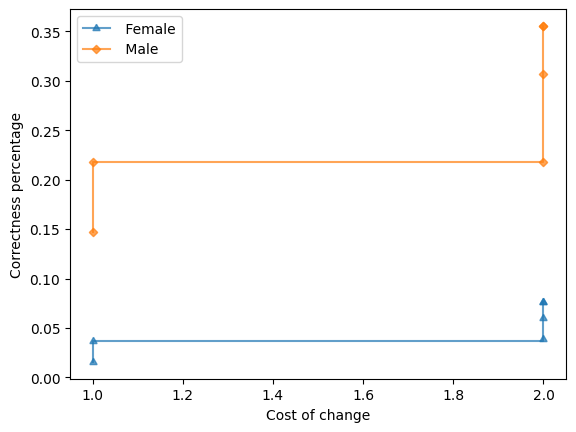

If hours-per-week = FullTime, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Female', 11.17% covered out of 4213
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Sales with correctness 0.21% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 2.98% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 5.74% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 5.96% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 8.09% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 8.09% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 9.79% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-ma

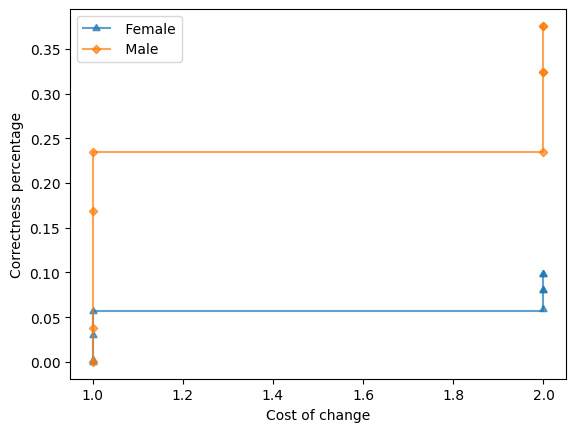

If Workclass =  Private, hours-per-week = FullTime, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 3.03% covered out of 4213
		Make occupation =  Prof-specialty with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 2.92% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 2.92% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 7.30% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 7.30% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 7.30% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.07
	Protected Subgroup ' Male', 5.67% covered out of 6606
		Make occupation =  Prof-specialty with correctness 9.86% and counterfactual c

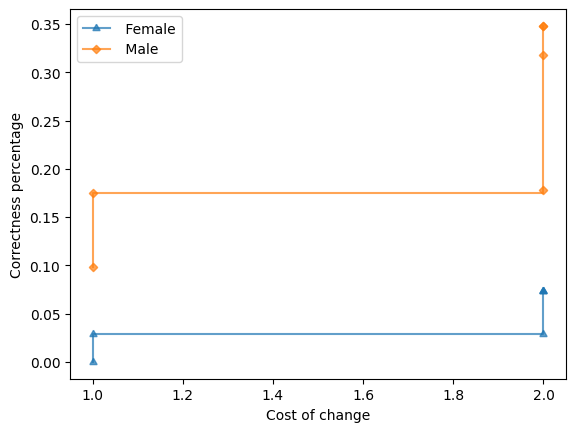

If hours-per-week = FullTime, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.89% covered out of 4213
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 1.32% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime with correctness 3.29% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 3.29% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 7.89% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 7.89% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 7.89% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 7.89% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.08


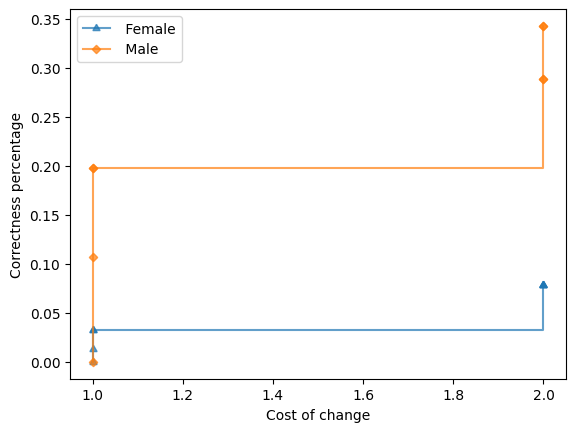

If hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Female', 4.31% covered out of 4213
		Make occupation =  Craft-repair with correctness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with correctness 1.18% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime with correctness 2.94% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with correctness 2.94% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 7.06% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 7.06% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 7.06% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 7.06% and counterfactual cost = 2.0.
		Aggregate cost of the above

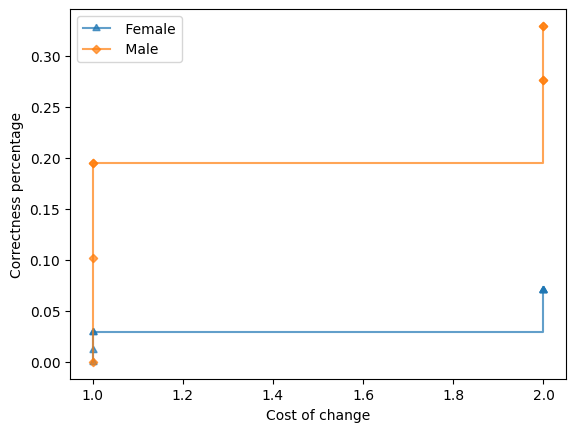

If Workclass =  Private, education-num = 11:
	Protected Subgroup ' Female', 3.84% covered out of 4213
		Make education-num = 12 with correctness 2.07% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 6.90% and counterfactual cost = 2.67.
		Make Workclass =  Self-emp-not-inc, education-num = 13 with correctness 6.90% and counterfactual cost = 3.67.
		Make Workclass =  Self-emp-inc, education-num = 13 with correctness 6.90% and counterfactual cost = 3.67.
		Aggregate cost of the above recourses = 0.07
	Protected Subgroup ' Male', 3.09% covered out of 6606
		Make education-num = 12 with correctness 12.50% and counterfactual cost = 1.33.
		Make education-num = 13 with correctness 27.88% and counterfactual cost = 2.67.
		Make Workclass =  Self-emp-not-inc, education-num = 13 with correctness 27.88% and counterfactual cost = 3.67.
		Make Workclass =  Self-emp-inc, education-num = 13 with correctness 32.21% and counterfactual cost = 3.67.
		Aggregate cost of the abov

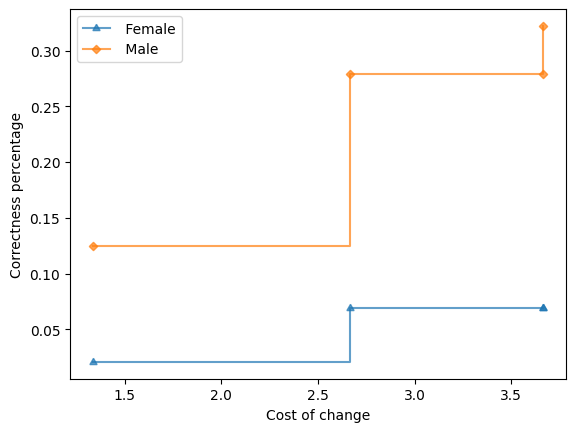

In [32]:
top_rules, subgroup_costs = gfacts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)